# VGG v4 - 224,224 - Data Augmentation

## Activa GPU rey, desde notebooks settings

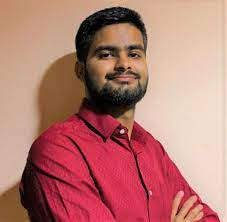

## Librerias

Instalar roboflow e importar el resto de las librerias.

Tip: luego de correr pip install roboflow, apretar en la cruz que sale para ocultar el output horrible.

In [1]:
!pip install roboflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.3/155.3 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 kB 8.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 7.7 MB/s eta 0:00:00
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=1335b366a21f18fb544a624362f54c508535b053349a6c6f5708b67c48ff4296
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.1.1
    Uninstalling pyparsing-3.1.1:
      

In [2]:
import numpy as np
import cv2
from keras.applications.mobilenet import MobileNet
from keras.applications import VGG16
from keras.models import Model, Sequential
from keras.layers import Dense, GlobalAveragePooling2D, Flatten, Dropout
from keras.optimizers import Adam
from keras import layers
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import plot_model
import pandas as pd
from roboflow import Roboflow
from keras import callbacks
from google.colab.patches import cv2_imshow

## RoboFlow

Importar datos utilizando la API de roboflow: esto viene del export que sale de RoboFlow, seleccionando metodo de export "code" y "multiclass"

In [3]:
rf = Roboflow(api_key="RIRyho5TtyNxqxJqhn2s")
project = rf.workspace("fall-detection-nzoyh").project("fall-detection-bb")
dataset = project.version(9).download("multiclass")

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to fall-detection-bb-9 in multiclass:: 100%|██████████| 2411/2411 [00:01<00:00, 1586.10it/s]


Guardamos la version

In [4]:
version = int(dataset.version)
version

9

Funcion **move to folder**:

Generar las carpetas fall y no fall y meter las imagenes donde correspondan segun lo que dicen los CSV

In [5]:
import os
import shutil
import pandas as pd

def move_to_folders(version, folder):
  # Define the paths
  image_folder = f"/content/fall-detection-bb-{version}/{folder}"
  csv_file = f"/content/fall-detection-bb-{version}/{folder}/_classes.csv"
  output_folder = f"/content/fall-detection-bb-{version}/{folder}"

  # Read the CSV file
  data = pd.read_csv(csv_file)
  data['label'] = ['fall' if x == 1 else 'no fall' for x in data[' fall']]

  # Create folders for each label
  for label in ["fall", "no fall"]:
      folder_path = os.path.join(output_folder, label)
      os.makedirs(folder_path, exist_ok=True)

  # Move images to their corresponding folders
  for index, row in data.iterrows():
      image_name = row["filename"]
      label = row["label"]

      source_path = os.path.join(image_folder, image_name)
      destination_folder = os.path.join(output_folder, label)
      destination_path = os.path.join(destination_folder, image_name)

      # Move the image to the destination folder
      shutil.move(source_path, destination_path)

  print("Images moved successfully!")

Luego de correr esto, comprobar que en cada carpeta de train, test y valid ahora hay dos carpetas dentro, fall y no fall.

In [6]:
move_to_folders(version,'train')
move_to_folders(version,'valid')
move_to_folders(version,'test')

Images moved successfully!
Images moved successfully!
Images moved successfully!


## Data Augmentation

In [7]:
_, _, files = next(os.walk(f"/content/fall-detection-bb-{version}/train/fall"))
file_count1 = len(files)
_, _, files = next(os.walk(f"/content/fall-detection-bb-{version}/train/no fall"))
file_count2 = len(files)

file_count1 + file_count2

2036

Tarda 2 minutos

In [8]:
import imgaug.augmenters as iaa

def augmentate_dataset(main_path):
  """ Augmentation a imagenes originales, guardandolas en el mismo path. """

  fall_path = main_path + '/fall'
  no_fall_path = main_path + '/no fall'

  augmentations = [
    iaa.Grayscale(alpha=(0.8, 1.0),random_state=42), # Convert images to grayscale
    iaa.Affine(rotate=(-15, 15),random_state=42),  # Apply rotations between -15 and 15 degrees
    iaa.Multiply((0.4, 0.55),random_state=42)  # Adjust brightness by multiplying values
    ]

  for path in [fall_path,no_fall_path]:

    # Entrar a cada path
    for filename in os.listdir(path):
        image_path = os.path.join(path, filename)
        image = cv2.imread(image_path)

        # Aplicar transformacion y guardar fotos aumentadas
        for idx, augmentation in enumerate(augmentations):
            augmented_image = augmentation.augment_image(image)
            transformed_filename = f'{filename}_augmented_{idx}.jpg'
            cv2.imwrite(os.path.join(path, transformed_filename), augmented_image)

## Data Prep for Model

No hace falta tocar nada.

Lo que hace este paso es generar el formato dataset que luego tomara el modelo para entrenar y predecir.

In [9]:
# Rutas de las carpetas de entrenamiento, validación y prueba
train_dir = f'/content/fall-detection-bb-{version}/train'
valid_dir = f'/content/fall-detection-bb-{version}/valid'
test_dir = f'/content/fall-detection-bb-{version}/test'

# Tamaño de redimensionamiento deseado
target_size = (224, 224)

# Augmentation
augmentate_dataset(train_dir)

# Definir la transformación de datos para el conjunto de entrenamiento
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalizar los valores de píxeles a [0, 1]
    preprocessing_function=lambda x: cv2.resize(x, target_size)
)

# Definir la transformación de datos para el conjunto de validación y prueba
valid_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=lambda x: cv2.resize(x, target_size)
)

test_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=lambda x: cv2.resize(x, target_size)
)

# Crear generadores de datos a partir de las carpetas
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,  # Tamaño de las imágenes de entrada
    batch_size=32,  # Tamaño del lote (batch)
    class_mode='binary', # Modo de clasificación (categórica en este caso)
    classes = ['no fall','fall'],
    shuffle=False
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=target_size,
    batch_size=32,
    class_mode='binary',
    classes = ['no fall','fall'],
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    batch_size=32,
    class_mode='binary',
    classes = ['no fall','fall'],
    shuffle=False
)

Found 8144 images belonging to 2 classes.
Found 270 images belonging to 2 classes.
Found 97 images belonging to 2 classes.


In [ ]:
test_generator.class_indices

{'no fall': 0, 'fall': 1}

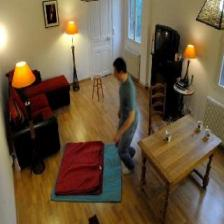

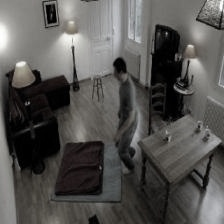

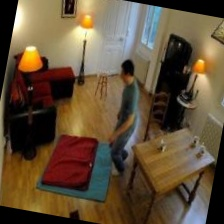

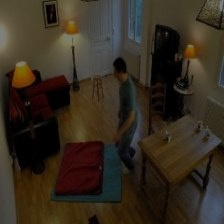

In [10]:
img_paths = [f'/content/fall-detection-bb-{version}/train/fall/000006_jpg.rf.fe9b915f751856310eb82f1549df4ae3.jpg',
             f'/content/fall-detection-bb-{version}/train/fall/000006_jpg.rf.fe9b915f751856310eb82f1549df4ae3.jpg_augmented_0.jpg',
             f'/content/fall-detection-bb-{version}/train/fall/000006_jpg.rf.fe9b915f751856310eb82f1549df4ae3.jpg_augmented_1.jpg',
             f'/content/fall-detection-bb-{version}/train/fall/000006_jpg.rf.fe9b915f751856310eb82f1549df4ae3.jpg_augmented_2.jpg']

for img_path in img_paths:
  image = cv2.imread(img_path)
  cv2_imshow(image)

## Define model

En este ejemplo cargamos el modelo VGG16, con shape 224,224

In [11]:
def load_vgg16():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))

    for layer in base_model.layers:
      layer.trainable = False

    return base_model

base_model = load_vgg16()

58889256/58889256 [==============================] - 0s 0us/step


Numero de clases: no tocar, estmaos haciendo binario

Capas densas, se puede tocar si se quiere

In [12]:
num_classes = 2

model = Sequential()
model.add(base_model)

model.add(Flatten())

model.add(Dense(128,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

Compilar.

In [13]:
model.compile(optimizer=Adam(learning_rate=0.001),
                     loss='binary_crossentropy',
                     metrics=[tf.keras.metrics.AUC()])

Visualizar

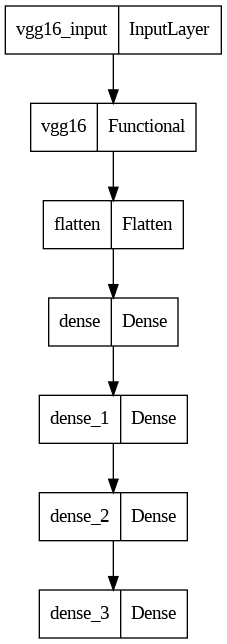

In [14]:
plot_model(model)

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 128)               3211392   
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 17,936,449
Trainable params: 3,221,761
Non

Preparamos todo para poder guardar el mejor modelo en drive. Darle OK cuando te salte la ventana emergente.

In [16]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [17]:
if not os.path.isdir('/content/gdrive/MyDrive/bestmodels'):
  print('creando best model para vos bebe')
  os.makedirs('/content/gdrive/MyDrive/bestmodels')
else:
  print('ya existe la carpeta, good')

ya existe la carpeta, good


Preparar callbacks de early stopping y de best model.

!!! Cambiar el nombre del modelo a algo propio

In [18]:
es_callback = callbacks.EarlyStopping(
    monitor='val_auc',
    patience=10,
    verbose=1)

model_input= input()

model_name = f'{model_input}.h5' # MODIFICAR CON LO PROPIO

mc_callback = callbacks.ModelCheckpoint(
    filepath=f'/content/gdrive/MyDrive/bestmodels/{model_name}',
    monitor='val_auc',
    mode='max',
    save_best_only=True)

vgg_5_sept


In [19]:
model_name

'vgg_5_sept.h5'

Ejecutar

In [20]:
history = model.fit(train_generator, epochs=100,
                    validation_data=valid_generator,
                    callbacks = [es_callback,mc_callback])

Epoch 1/100
255/255 [==============================] - 50s 151ms/step - loss: 0.6015 - auc: 0.8347 - val_loss: 1.3675 - val_auc: 0.7977
Epoch 2/100
255/255 [==============================] - 33s 129ms/step - loss: 0.2217 - auc: 0.9677 - val_loss: 1.5068 - val_auc: 0.7746
Epoch 3/100
255/255 [==============================] - 36s 139ms/step - loss: 0.1866 - auc: 0.9771 - val_loss: 0.8199 - val_auc: 0.8182
Epoch 4/100
255/255 [==============================] - 34s 132ms/step - loss: 0.1664 - auc: 0.9819 - val_loss: 1.3303 - val_auc: 0.7843
Epoch 5/100
255/255 [==============================] - 34s 132ms/step - loss: 0.2402 - auc: 0.9644 - val_loss: 1.5419 - val_auc: 0.7711
Epoch 6/100
255/255 [==============================] - 34s 133ms/step - loss: 0.1287 - auc: 0.9884 - val_loss: 3.9329 - val_auc: 0.5228
Epoch 7/100
255/255 [==============================] - 35s 136ms/step - loss: 0.1038 - auc: 0.9928 - val_loss: 0.5559 - val_auc: 0.8698
Epoch 8/100
255/255 [===========================

## Resultados

Cargar best model

In [21]:
best_model = tf.keras.models.load_model(f'/content/gdrive/MyDrive/bestmodels/{model_name}')

Vemos resultados en test con TF. Esta no es la que vamos a anotar en el excel.

In [22]:
results = best_model.evaluate(test_generator, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test AUC: {}'.format(results[1]))

Test Loss: 0.16615258157253265
Test AUC: 0.9849098324775696


Ploteamos

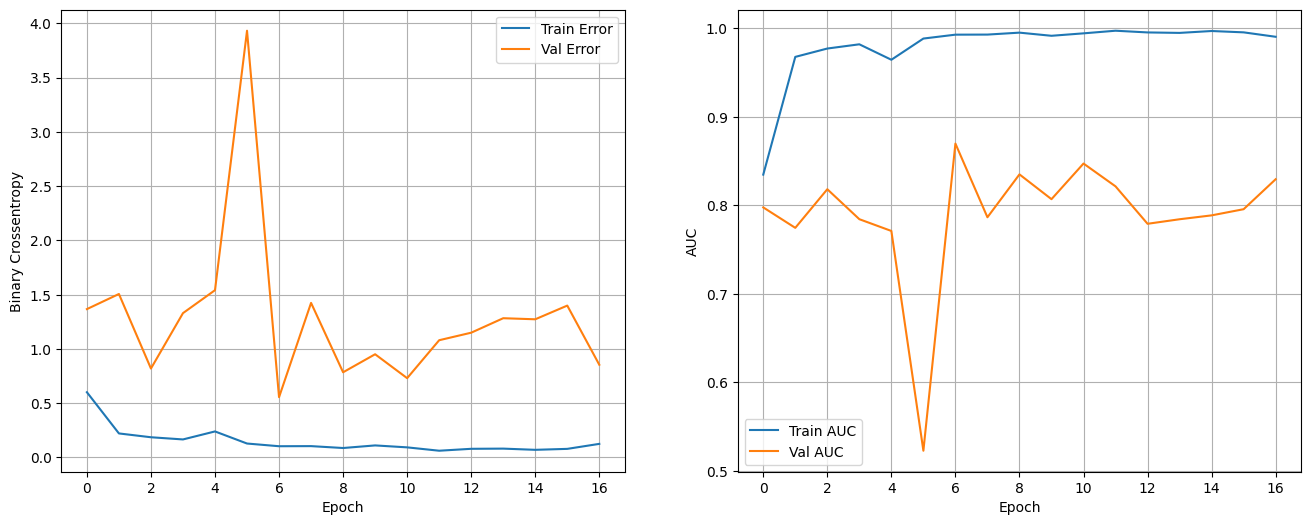

In [23]:
def show_loss_auc_evolution(history):

    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Binary Crossentropy')
    ax1.plot(hist['epoch'], hist['loss'], label='Train Error')
    ax1.plot(hist['epoch'], hist['val_loss'], label = 'Val Error')
    ax1.grid()
    ax1.legend()

    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('AUC')
    ax2.plot(hist['epoch'], hist['auc'], label='Train AUC')
    ax2.plot(hist['epoch'], hist['val_auc'], label = 'Val AUC')
    ax2.grid()
    ax2.legend()

    plt.show()

show_loss_auc_evolution(history)

Insight de resultados

In [24]:
true_labels = test_generator.labels
true_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [25]:
predictions = best_model.predict(test_generator)
preds = np.round(predictions).flatten()

4/4 [==============================] - 1s 171ms/step


Accuracy y AUC de sklearn

!! Ver que da distinta a la de TF. Es porque tienen configurados disitntos thresholds.

In [26]:
from sklearn.metrics import accuracy_score, roc_auc_score

print(f'Accuracy en test: {accuracy_score(true_labels,preds)}')
print(f'AUC en test: {roc_auc_score(true_labels,preds)}')

Accuracy en test: 0.9484536082474226
AUC en test: 0.9427927927927927


Classification report

In [27]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

print(classification_report(true_labels,preds))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96        60
           1       0.94      0.92      0.93        37

    accuracy                           0.95        97
   macro avg       0.95      0.94      0.95        97
weighted avg       0.95      0.95      0.95        97



Matriz de confusion

In [28]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(False)

Confusion matrix, without normalization
[[58  2]
 [ 3 34]]


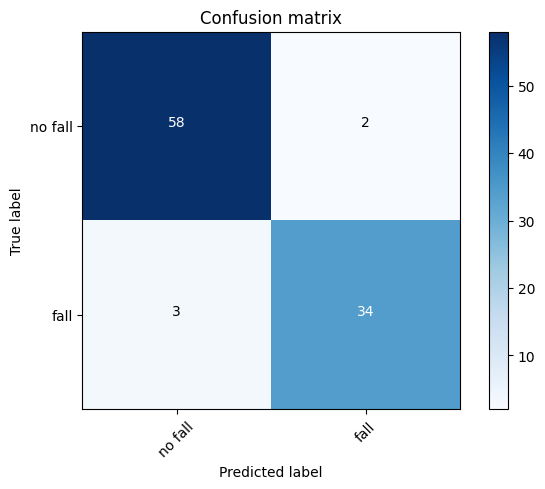

In [29]:
class_names = list(test_generator.class_indices.keys())
plot_confusion_matrix(confusion_matrix(true_labels,preds),class_names)
plt.show()